In [2]:
%load_ext autoreload
%autoreload 2
import os, re

import discovery as ds
# import PTMCMCSampler

from tqdm import tqdm

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as pp

import jax
import jax.numpy as jnp
import glob
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import numpyro
from numpyro import distributions as dist, infer
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam
plt.style.use("../data/meyers_latex.mplstyle")
import sys
sys.path.append("../modules")
from transformations import simple_dict_transformation
import models as lncass_models
from lncass import PRIOR_DICT
from jax.scipy.optimize import minimize

2024-08-14 20:34:03.143981: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
# psrname = 'J1643-1224'
psrname = 'J1909-3744'
# maindir = '/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/repositories/pulsar_timing/pulsar_discovery/main_fork/discovery'
maindir = '../'
psrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob(f'{maindir}/data/[JB]*-12p5.feather'))]
psrs = psrs[:20]
Tspan_pta = ds.getspan(psrs)
n_rn_freqs = 30
names = [psr.name for psr in psrs]

In [4]:
names += ['gw']

In [5]:
import json
noisedict = json.load(open('../data/channelized_12p5yr_v3_full_noisedict.json', 'r'))
for psr in psrs:
    psr.noisedict = noisedict

In [6]:
model, gl = lncass_models.create_rn_pta_model(psrs, n_rn_freqs, array=True, cond=0, tnequad=True)

In [7]:
jlogl = jax.jit(jax.value_and_grad(gl.logL))

In [8]:
%%timeit
jlogl({**{f'{psrname}_red_noise_log10_rho(30)': np.random.rand(30)*6 + -10 for ii, psrname in enumerate(names)}, **{'crn_log10_rho(30)': np.random.rand(30)*6 + -10}})

2.07 ms ± 46.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
jlogx = jax.jit(jax.value_and_grad(simple_dict_transformation(gl.logL)))

In [10]:
arr = np.array([ np.random.rand(30)*6 + -10 for ii, psrname in enumerate(names)])

In [11]:
%%timeit
jlogx(arr)

312 µs ± 35.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
# set up the sampler
# we set target_accept_prob=0.99, which is quite high.
# But I was getting a reasonable number of divergences when I didn't set it this high,
# and this has significantly reduced the percentage of divergences from ~25% down to ~0.5%
lncass_outliers_sampler = infer.MCMC(
    infer.NUTS(model, max_tree_depth=10,dense_mass=False,
    forward_mode_differentiation=False, target_accept_prob=0.99),
    num_warmup=5000,
    num_samples=2000,
    num_chains=4,
    progress_bar=True,
    chain_method='vectorized'
)

In [25]:
# set up priors on hyperparameters. For now we fix $\tau$ and \sigma_\lambda, and we sample \mu
prior_dict = {**PRIOR_DICT, 'tau': dist.Uniform(4.999, 5.),
              'sigma_lambda':dist.Uniform(14.999, 15.001),
              'mu_lambda': dist.Uniform(-50, 50)}

# sample!!
with numpyro.validation_enabled():
    lncass_outliers_sampler.run(jax.random.PRNGKey(2345), prior_dict=prior_dict)

sample: 100%|██████████| 7000/7000 [2:27:32<00:00,  1.26s/it]  


In [26]:
import arviz as az
idata = az.from_numpyro(
                    lncass_outliers_sampler
                    )
idata.to_netcdf('lncass_outliers_sampler.netcdf')

'lncass_outliers_sampler.netcdf'

In [27]:
lncass_outliers_sampler.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta_xi_rn[0,0]     -0.01      0.90     -0.03     -1.46      1.53   1435.06      1.00
       beta_xi_rn[0,1]      0.01      0.99      0.03     -1.58      1.66   1466.01      1.00
       beta_xi_rn[0,2]      0.00      0.99      0.03     -1.57      1.66   1287.34      1.00
       beta_xi_rn[0,3]     -0.07      1.00     -0.06     -1.62      1.61   1315.08      1.00
       beta_xi_rn[0,4]     -0.03      0.97     -0.01     -1.56      1.61   1679.35      1.00
       beta_xi_rn[0,5]     -0.09      0.97     -0.06     -1.69      1.52   1441.93      1.00
       beta_xi_rn[0,6]     -0.05      0.99     -0.05     -1.66      1.59   1552.25      1.00
       beta_xi_rn[0,7]     -0.07      0.99     -0.07     -1.66      1.56   1416.48      1.01
       beta_xi_rn[0,8]     -0.10      0.99     -0.10     -1.71      1.53   1387.12      1.00
       beta_xi_rn[0,9]     -0.04      1.00     -0.02     -1.63      1

In [28]:
samples = lncass_outliers_sampler.get_samples()

In [29]:
samples['log10_rho'].shape

(8000, 30, 21)

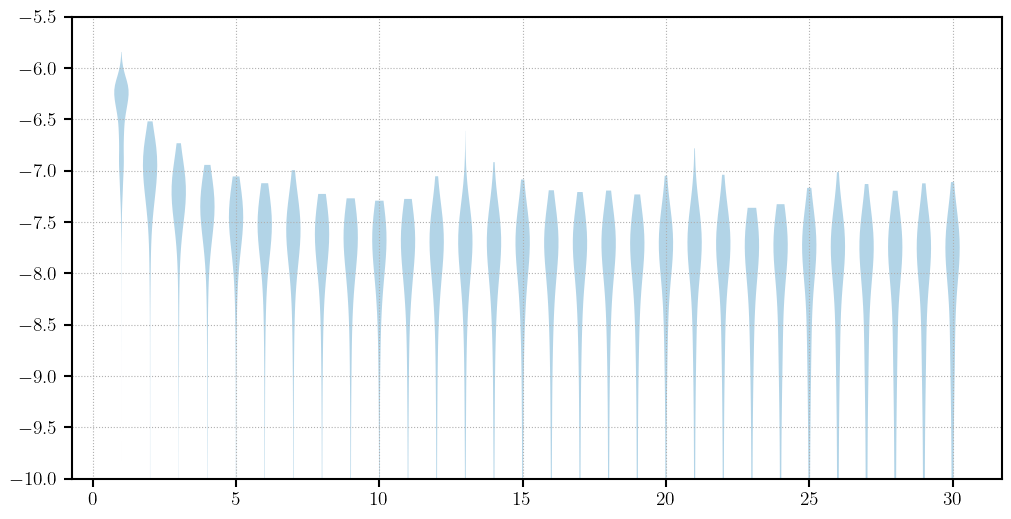

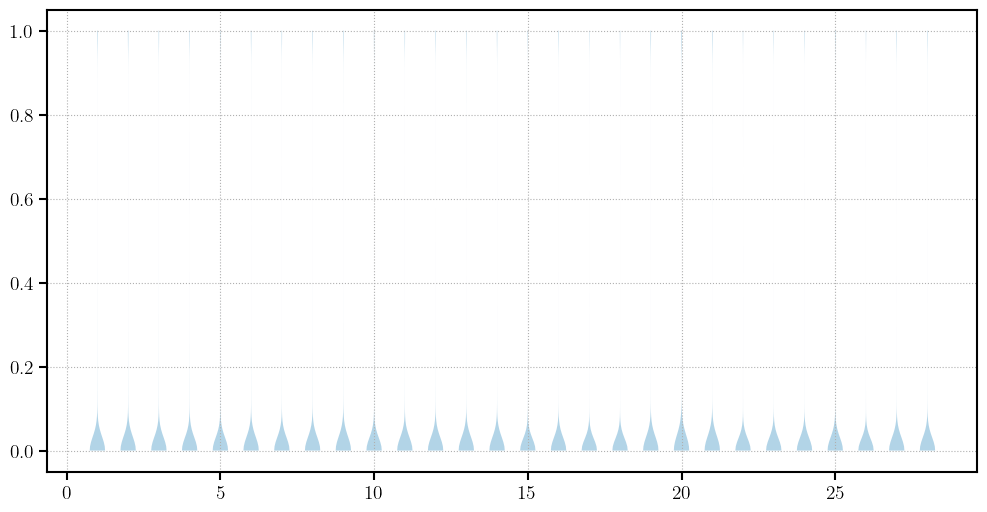

In [30]:
plt.figure(figsize=(12, 6))
plt.violinplot(samples['log10_rho'][:, :, -1].T, showextrema=False)
plt.ylim(-10, -5.5)
plt.show()
plt.figure(figsize=(12, 6))
plt.violinplot(samples['lambdas_rn'][:, :, -1].T, showextrema=False)
plt.show()

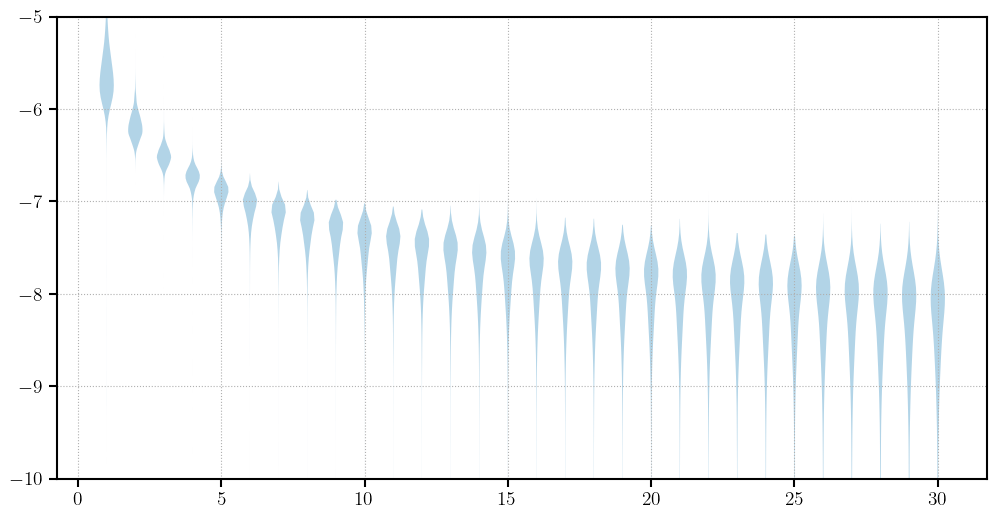

In [31]:
plt.figure(figsize=(12, 6))
plt.violinplot(samples['log10_rho'][:, :, 1].T, showextrema=False)
plt.ylim(-10, -5)
plt.show()

In [32]:
model_pl, gl_pl = lncass_models.create_pta_model_plrn_plgw(psrs, n_rn_freqs, tnequad=True)

In [33]:
# set up the sampler
# we set target_accept_prob=0.99, which is quite high.
# But I was getting a reasonable number of divergences when I didn't set it this high,
# and this has significantly reduced the percentage of divergences from ~25% down to ~0.5%
fspec_outliers_sampler = infer.MCMC(
    infer.NUTS(model_pl, max_tree_depth=10,dense_mass=False,
    forward_mode_differentiation=False, target_accept_prob=0.8),
    num_warmup=5000,
    num_samples=2000,
    num_chains=1,
    progress_bar=True,
    chain_method='vectorized'
)

In [34]:
# set up priors on hyperparameters. For now we fix $\tau$ and \sigma_\lambda, and we sample \mu
# prior_dict = {**PRIOR_DICT, 'tau': dist.Uniform(4.999, 5.),
#               'sigma_lambda':dist.Uniform(14.999, 15.001),
#               'mu_lambda': dist.Uniform(-50, 50)}

# sample!!
with numpyro.validation_enabled():
    fspec_outliers_sampler.run(jax.random.PRNGKey(35))# , prior_dict=prior_dict)

sample: 100%|██████████| 7000/7000 [09:18<00:00, 12.53it/s, 127 steps of size 3.82e-02. acc. prob=0.95]


In [35]:
pl_samples = fspec_outliers_sampler.get_samples()

(-10.0, -5.5)

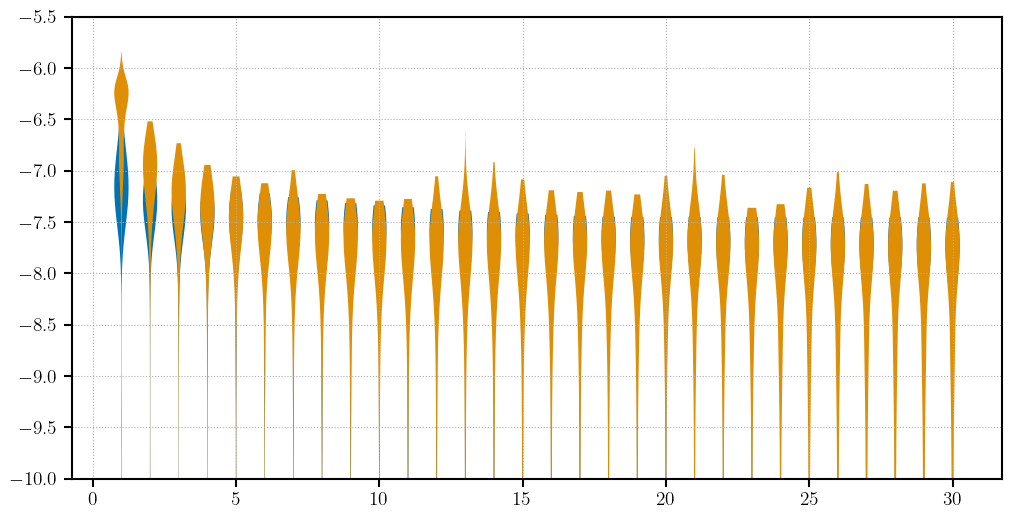

In [36]:
freqs = np.arange(1, 31) / Tspan_pta
fyr = 1 / 365.25 / 86500
rhos = []
for log10_A, gamma in zip(pl_samples['log10_A_rn'][:, -1], pl_samples['log10_gamma_rn'][:, -1]):
    rhos.append(jnp.log10(10**(2*log10_A) / (12 * np.pi**2) * (freqs / fyr)**(-gamma) * fyr**-3 / Tspan_pta) / 2)
rhos = np.array(rhos)

plt.figure(figsize=(12, 6))
parts = plt.violinplot(rhos, showextrema=False)
for b in parts['bodies']:
    b.set_alpha(1)
parts = plt.violinplot(samples['log10_rho'][:, :, -1].T, showextrema=False)
for b in parts['bodies']:
    b.set_alpha(1)
plt.ylim(-10, -5.5)

(-10.0, -5.5)

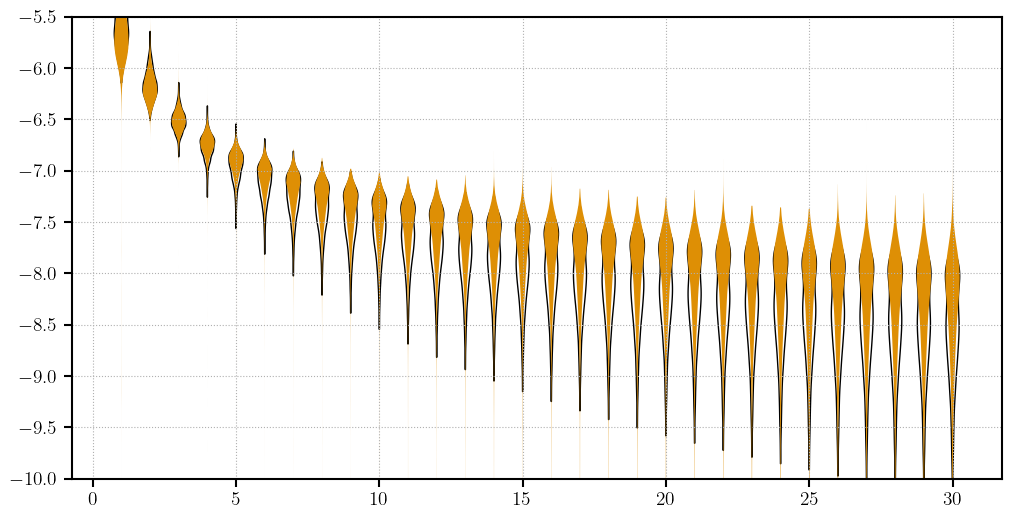

In [37]:
rhos = []
for log10_A, gamma in zip(pl_samples['log10_A_rn'][:, 1], pl_samples['log10_gamma_rn'][:, 1]):
    rhos.append(jnp.log10(10**(2*log10_A) / (12 * np.pi**2) * (freqs / fyr)**(-gamma) * fyr**-3 / Tspan_pta) / 2)
rhos = np.array(rhos)
plt.figure(figsize=(12, 6))
parts = plt.violinplot(rhos, showextrema=False)
for b in parts['bodies']:
    b.set_alpha(1)
    b.set_facecolor('none')
parts = plt.violinplot(samples['log10_rho'][:, :, 1].T, showextrema=False)
for b in parts['bodies']:
    b.set_alpha(1)
    b.set_facecolor('C1')

plt.ylim(-10, -5.5)

In [38]:
fspec_outliers_sampler

In [39]:
import arviz as az
idata = az.from_numpyro(
                    fspec_outliers_sampler
                    )
idata.to_netcdf('fspec_outliers_sampler.netcdf')

'fspec_outliers_sampler.netcdf'